# Visión por computadora

## Conjunto de datos

### Descripción

https://universe.roboflow.com/myworkspace-iraqv/wildfire_full  
<br>
* <u>Tipo de problema a resolver</u>: Detección de objetos.  
<br>
* <u>Objetivo</u>: Detectar focos de incendio.  
<br>
* <u>Motivación</u>: La Amazonía se está quemando a un ritmo alarmante, afectando el clima, la biodiversidad y el calentamiento global.
Detectar incendios de manera temprana podría marcar la diferencia para evitar daños mayores.

* <u>Créditos</u>:  

 - **title**: Wildfire_Full Dataset
 - **type**: Open Source Dataset
 - **author**: MyWorkspace
 - **URL**: https://universe.roboflow.com/myworkspace-iraqv/wildfire_full
 - **published**: Roboflow Universe
 - **publisher**: Roboflow
 - **year**: 2024
 - **month**: oct

In [ ]:
!pip install roboflow

In [ ]:
import json
import os
import shutil
import random
import yaml
import math

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from roboflow import Roboflow
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from PIL import Image, ImageDraw, ImageFont
from collections import Counter, defaultdict


In [ ]:
# Download desde Roboflow
rf = Roboflow(api_key="tvpbe4I4XLcB14dkNovn")
project = rf.workspace("myworkspace-iraqv").project("wildfire_full")
version = project.version(1)

loading Roboflow workspace...
loading Roboflow project...


### Formatos

In [ ]:
# Dataset en diferentes formatos
dataset_formats = {
    'json':[
      'coco',
      'coco-mmdetection',
      'createml',
      'paligemma',
      'florence2-od',
      'openai'],
    'xml':[
      'voc'],
    'txt':[
      'darknet',
      'yolokeras',
      'yolov4pytorch',
      'yolov4scaled',
      'yolov5-obb',
      'mt-yolov6',
      'yolov5',
      'yolov7',
      'yolov8',
      'yolov8-obb',
      'yolov9',
      'yolov11'],
    'csv':[
      'tensorflow',
      'retinanet',
      'multiclass'],
    'bin':[
      'clip',
      'tfrecord',
      'benchmarker']
}

#### COCO (Common Objects in Context)

El formato COCO es un formato JSON que contiene varios campos estructurados para representar la información relacionada con las imágenes, sus anotaciones (etiquetas) y las categorías de objetos.  
Componentes des este formato:  
1. **images** (Imágenes)  
Cada imagen en el dataset tiene una entrada en la sección images. Esta entrada describe detalles sobre la imagen, como el nombre del archivo, el tamaño y un identificador único.
 * id: Un identificador único para la imagen.
 * file_name: El nombre del archivo de la imagen.
 * height: La altura de la imagen (en píxeles).
 * width: El ancho de la imagen (en píxeles).  

2. **annotations** (Anotaciones)  
Las anotaciones contienen la información sobre los objetos presentes en las imágenes. Cada anotación describe un objeto detectado en una imagen, con detalles como la categoría, la posición (por ejemplo, la caja delimitadora o las coordenadas de segmentación) y otras propiedades.
 * id: Un identificador único para la anotación.
 * image_id: El identificador de la imagen a la que pertenece esta anotación (referencia al campo id en la sección de imágenes).
 * category_id: La categoría del objeto anotado (referencia a un ID en el campo categories).
 * bbox: Las coordenadas de la caja delimitadora que rodea el objeto en la imagen, en formato [x_min, y_min, ancho, alto].
 * area: El área del objeto en píxeles.
 * iscrowd: Un valor que indica si el objeto es un "grupo" de objetos (por ejemplo, si varios objetos están agrupados, se podría marcar como 1, de lo contrario 0).  
3. **categories** (Categorías)  
En esta sección se definen las categorías de objetos que se pueden encontrar en las imágenes.  Cada categoría tiene un identificador único.
 * id: Un identificador único para la categoría.
 * name: El nombre de la categoría.
 * supercategory: Una categoría más general a la que pertenece esta categoría.
4. **segmentation** (Segmentación)  
COCO también soporta tareas de segmentación (en las que no solo se detecta el objeto, sino que se identifican los píxeles exactos que componen el objeto). En lugar de solo las coordenadas de una caja delimitadora, el campo de segmentación puede contener los contornos de un objeto.
 * segmentación puede estar representada por polígonos (en formato de coordenadas de los vértices del objeto) o por una máscara binaria (en donde los píxeles que corresponden al objeto son etiquetados).

#### COCO-MMD (COCO para MMDetection)

Es una variante del formato COCO estándar, adaptada específicamente para su uso con el framework MMDetection.   
MMDetection es un framework basado en PyTorch para la detección de objetos y tareas relacionadas, desarrollado por OpenMMLab.  
<br>
El archivo COCO-MMD tiene una estructura jerárquica que contiene las siguientes secciones principales:

1 - images: Información sobre las imágenes del dataset.  
 - id: Identificador único de la imagen.
 - file_name: Nombre del archivo de la imagen.
 - height: Altura de la imagen (en píxeles).
 - width: Ancho de la imagen (en píxeles).
 - date_captured: Fecha de captura de la imagen (opcional).
 - license: ID de la licencia bajo la cual se distribuye la imagen.

2 - annotations: Anotaciones sobre los objetos dentro de las imágenes, incluyendo las cajas delimitadoras (bounding boxes), segmentaciones y otras etiquetas.  
 - id: Identificador único de la anotación.
 - image_id: ID de la imagen a la que pertenece la anotación.
 - category_id: ID de la categoría del objeto (referencia a categories).
 - bbox: Las coordenadas de la caja delimitadora, en formato [x_min, y_min, width, height] (y en COCO-MMD, también se incluye un ángulo de rotación, si es necesario, como el quinto valor).
 - segmentation: Coordenadas del polígono de segmentación, si está disponible (como una lista de coordenadas de los puntos del contorno del objeto). Puede ser un polígono o una máscara binaria.
 - area: Área total del objeto, en píxeles (solo en el caso de detección o segmentación de objetos).
 - iscrowd: Si el objeto es un "grupo" o "multiclase" (por ejemplo, múltiples objetos juntos, como una multitud), se marca como 1, si no es así se marca como 0.  

3 - categories: Definición de las categorías de objetos.
 - id: Identificador único de la categoría.
 - name: Nombre de la categoría.
 - supercategory: Categoría más general a la que pertenece la categoría.  

4 - licenses (opcional): Información sobre las licencias de uso del dataset (si es aplicable).  
 - id: Identificador único de la licencia.
 - name: Nombre de la licencia (por ejemplo, "MIT License").
 - url: Enlace a los términos de la licencia.

5 - info (opcional): Información general sobre el dataset, como el nombre y la versión.
 - description: Descripción del dataset.
 - url: Enlace a la página del dataset.
 - version: Versión del dataset.
 - year: Año de creación del dataset.
 - contributor: Nombre de la organización o el autor del dataset.


#### CreateML

El formato CreateML es utilizado principalmente por la herramienta Create ML de Apple, que es parte del ecosistema de Core ML.   

Create ML es una herramienta diseñada para permitir a los desarrolladores crear, entrenar e implementar modelos de aprendizaje automático en dispositivos Apple (como iPhones, iPads, Macs, etc.) de manera accesible, sin necesidad de un entorno complejo de programación.

#### PaliGemma

PaliGemma es un modelo de lenguaje de visión (VLM) abierto y ligero inspirado en PaLI-3 (Pretrained and Lightweight Image), y se basa en componentes abiertos como el método SigLIP (Signal Language Image Processing) el modelo de visión y el lenguaje Gemma automático.   

PaliGemma toma imágenes y texto como entradas y puede responder preguntas sobre con detalles y contexto, lo que significa que PaliGemma puede realizar un análisis imágenes y proporcionar estadísticas útiles, como subtítulos para imágenes y videos cortos, detección de objetos y lectura de texto incorporado en imágenes.

Hay dos conjuntos de modelos PaliGemma, un conjunto de uso general y un conjunto orientado a la investigación:

* PaliGemma: Modelos previamente entrenados de uso general que pueden ajustarse en una variedad de tareas.  
* PaliGemma-FT: Modelos orientados a la investigación que se ajustan en conjuntos de datos de investigación específicos.

#### Florence 2

Modelo de inteligencia artificial multimodal desarrollado por Microsoft.

El formato Florence2-OD (Object Detection) es un formato utilizado para representar datasets de detección de objetos con la arquitectura Florence2 de Microsoft.   

Su estructura es similar a otros formatos populares como COCO, pero adaptada a las necesidades específicas de Florence2, especialmente en el contexto de tareas multimodales en el procesamiento de imágenes y texto.

#### OpenAI


El formato JSON utilizado por OpenAI para tareas de detección de objetos (Object Detection, OD) es una estructura estándar que contiene información sobre las imágenes, las anotaciones de las cajas delimitadoras (bounding boxes) de los objetos presentes en esas imágenes, y las categorías de dichos objetos.

Se puede hacer una analogía con formatos populares como COCO o Pascal VOC.

#### Pascal VOC

El formato Pascal VOC es uno de los formatos más conocidos y utilizados en visión por computadora para la detección de objetos, segmentación de instancias y clasificación de imágenes.   

Es un formato XML que se usa principalmente para almacenar las anotaciones de los objetos presentes en las imágenes de un dataset, incluyendo las coordenadas de las cajas delimitadoras (bounding boxes), las etiquetas de clase y, en algunos casos, las segmentaciones más detalladas de los objetos.  
<br>
Descripción de los campos:  

1- annotation: Es el nodo raíz del archivo XML y contiene toda la información sobre la imagen y sus anotaciones.

2- folder: Nombre del directorio o carpeta donde se encuentra la imagen (puede ser un nombre genérico como VOC2007 o el nombre de cualquier subdirectorio que contenga las imágenes).

3- filename: El nombre del archivo de imagen (por ejemplo, image_001.jpg).

4- path: La ruta completa del archivo de imagen en el sistema de archivos (es útil para algunos scripts que trabajan con rutas absolutas).

5- source:  

 - database: Nombre de la base de datos o del dataset (por ejemplo, Unknown si no se conoce).
 - annotation: Nombre de la anotación del dataset (en este caso VOC2007).
 - image: Fuente de la imagen (por ejemplo, flickr si la imagen proviene de Flickr).
 - flickrid: Identificador único de la imagen si proviene de Flickr (puede no estar presente si la imagen no proviene de esta fuente).

6- size: Información sobre el tamaño de la imagen:
 - width: Ancho de la imagen en píxeles.
 - height: Altura de la imagen en píxeles.
 - depth: Número de canales de color de la imagen (por ejemplo, 3 para imágenes RGB).

7- segmented: Indica si la imagen tiene una segmentación detallada. Generalmente, este campo es 0 (sin segmentación) o 1 (con segmentación).

8- object: Representa un objeto presente en la imagen. Para cada objeto, se puede tener múltiples entradas en este bloque, cada una correspondiente a un objeto diferente en la imagen.

 - name: Nombre de la clase del objeto (por ejemplo, dog, cat, car).
 - pose: Posición o pose del objeto (opcional, como Left, Right, etc.).
 - truncated: Indica si el objeto está recortado (si parte del objeto está fuera de los bordes de la imagen). 1 si está truncado, 0 si no lo está.
 - difficult: Indica si el objeto es difícil de detectar (por ejemplo, si está parcialmente cubierto o es pequeño). 1 si es difícil, 0 si no lo es.

9- bndbox: Caja delimitadora (bounding box) que delimita el objeto en la imagen.

 - xmin: Coordenada X de la esquina superior izquierda de la caja delimitadora.
 - ymin: Coordenada Y de la esquina superior izquierda de la caja delimitadora.
 - xmax: Coordenada X de la esquina inferior derecha de la caja delimitadora.
 - ymax: Coordenada Y de la esquina inferior derecha de la caja delimitadora.

#### YOLO (You Only Look Once)

El formato YOLO  es un formato de anotación utilizado para entrenar modelos de detección de objetos dentro del sistema YOLO, una de las arquitecturas más populares en visión por computadora.   

YOLO es un modelo de detección de objetos en tiempo real que divide la imagen en una cuadrícula y predice las ubicaciones de los objetos en cada celda de la cuadrícula.   

El formato de anotación YOLO se utiliza para indicar la localización y categoría de los objetos dentro de una imagen.

El formato de anotación YOLO es especialmente sencillo y se utiliza principalmente en el framework Darknet (el entorno original para YOLO), pero también es compatible con muchas implementaciones modernas de YOLO en otros frameworks como PyTorch y TensorFlow.

El formato de anotación YOLO se representa en archivos de texto plano con la extensión .txt.   
Por cada imagen, se genera un archivo de texto con el mismo nombre, pero con la extensión .txt que contiene las coordenadas de las cajas delimitadoras (bounding boxes) de los objetos en la imagen.   
Cada línea de este archivo corresponde a un único objeto detectado en la imagen.  
<br>
Cada línea en el archivo .txt tiene la siguiente estructura:  

*class_id x_center y_center width height*  
<br>
* class_id: El índice numérico de la clase del objeto detectado. Es un número entero que representa la clase del objeto, basado en un archivo de mapeo de clases (por ejemplo, 0 para "perro", 1 para "gato", etc.). Este índice está relacionado con un archivo que contiene los nombres de las clases (generalmente llamado classes.names).

* x_center: La coordenada x del centro de la caja delimitadora, normalizada entre 0 y 1. Este valor es la fracción del ancho total de la imagen. Por ejemplo, si el centro de la caja está en el medio de la imagen, x_center será 0.5.

* y_center: La coordenada y del centro de la caja delimitadora, normalizada entre 0 y 1. Este valor es la fracción de la altura total de la imagen. Por ejemplo, si el centro de la caja está en el medio de la imagen, y_center será 0.5.

* width: El ancho de la caja delimitadora, normalizado entre 0 y 1. Es la fracción del ancho total de la imagen. Un valor de width igual a 0.2 significa que la caja delimitadora tiene el 20% del ancho de la imagen.

* height: La altura de la caja delimitadora, normalizada entre 0 y 1. Es la fracción de la altura total de la imagen. Un valor de height igual a 0.3 significa que la caja delimitadora tiene el 30% de la altura de la imagen.

El archivo classes.names es un archivo de texto simple que contiene los nombres de las clases en el dataset. Cada clase se asigna a un número de índice.

##### darknet

Darknet es el framework original de YOLO creado por Joseph Redmon. Es una red neuronal que se entrenó y ejecutó usando este framework. Aunque actualmente muchos de los modelos más avanzados de YOLO usan PyTorch o TensorFlow, Darknet sigue siendo relevante en su versión original y es conocido por su eficiencia.
Darknet es el sistema en el que YOLOv1 hasta YOLOv3 fueron implementados.

##### yolokeras

YOLOkeras es una implementación de YOLO utilizando el framework Keras (que a su vez es una interfaz para TensorFlow). Esta variante busca hacer que la implementación de YOLO sea más accesible y fácil de usar dentro del ecosistema Keras, que es muy popular por su facilidad de uso.

##### yolov4pytorch

YOLOv4pytorch es una versión de YOLOv4 que ha sido adaptada para trabajar con el framework PyTorch. YOLOv4 es un modelo más avanzado que introduce mejoras en precisión y velocidad en comparación con sus predecesores.
Esta versión específicamente ha sido implementada por la comunidad en PyTorch, que es un marco muy popular para la investigación en visión por computadora.

##### yolov4scaled

YOLOv4scaled es una variante de YOLOv4 que introduce una mejora en el escalado de las arquitecturas para que sea más eficiente en diferentes resoluciones de imagen, es decir, optimiza el modelo para trabajar mejor en imágenes más grandes o más pequeñas manteniendo un buen equilibrio entre precisión y velocidad.

##### yolov5-obb

YOLOv5-obb es una extensión de YOLOv5 que añade soporte para la detección de cajas delimitadoras orientadas (OBB, por sus siglas en inglés Oriented Bounding Boxes). Esta mejora es útil para detectar objetos que no son rectangularmente alineados con los ejes de la imagen, como los objetos rotados.

##### mt-yolov6

MT-YOLOv6 es una implementación de YOLOv6 (probablemente una versión de YOLO desarrollada específicamente para detectar múltiples tipos de objetos o Multiple Targets). YOLOv6 es la sexta iteración de YOLO, conocida por ser una versión optimizada para el uso industrial con mejoras de precisión y velocidad.

##### yolov5

YOLOv5 es una de las versiones más conocidas de YOLO. Aunque YOLOv5 no fue desarrollado por el creador original de YOLO (Joseph Redmon), sino por Ultralytics, ha ganado una enorme popularidad debido a su rendimiento y la facilidad de uso.
Se ofrece en un formato listo para usar, con capacidades de entrenamiento y pruebas sencillas de configurar y ejecutar.

##### yolov7

YOLOv7 es una versión más avanzada que mejora el rendimiento de YOLOv4 y YOLOv5, incorporando nuevas técnicas de optimización y mejorando la precisión en la detección de objetos. Esta versión es conocida por su capacidad para detectar objetos pequeños con una alta precisión.

##### yolov8

YOLOv8 es la octava versión de la famosa arquitectura YOLO y sigue mejorando la precisión, velocidad y facilidad de implementación de las versiones anteriores. Esta versión también se centra en mantener un equilibrio entre eficiencia en tiempo de inferencia y precisión de detección.

##### yolov8-obb

YOLOv8-obb es una extensión de YOLOv8 que permite la detección de cajas delimitadoras orientadas (OBB). Similar a YOLOv5-obb, esto mejora la capacidad de YOLOv8 para detectar objetos que están rotados dentro de la imagen.

##### yolov9

YOLOv9 sería una continuación de las iteraciones anteriores de YOLO, aunque no es oficial. Algunas versiones de YOLO lanzadas como v9 podrían ser modificaciones personalizadas o experimentales de la comunidad.

##### yolov11

YOLOv11 también es una versión futura o experimental de YOLO, como sugiere el número de versión. Sin embargo, esto no está estandarizado y puede ser una implementación personalizada.

#### Formato CSV para TensorFlow

Los archivos CSV en TensorFlow generalmente siguen una estructura donde cada fila representa una caja delimitadora (bounding box) asociada con un objeto en una imagen. Cada línea suele tener información sobre la imagen y los detalles de la caja delimitadora:  
<br>
* filename: Nombre del archivo de la imagen.
* width: Ancho de la imagen.
* height: Alto de la imagen.
* class: Clase del objeto, generalmente representada como un número (por ejemplo, 1 para "perro", 2 para "gato").
* xmin: Coordenada x del vértice superior izquierdo de la caja delimitadora.
* ymin: Coordenada y del vértice superior izquierdo de la caja delimitadora.
* xmax: Coordenada x del vértice inferior derecho de la caja delimitadora.
* ymax: Coordenada y del vértice inferior derecho de la caja delimitadora.

#### Formato CSV para RetinaNet

RetinaNet es un modelo de detección de objetos conocido por su capacidad de manejar desequilibrio de clases mediante una técnica llamada Focal Loss. El formato CSV para RetinaNet generalmente sigue un formato similar al de otros modelos de detección, pero puede tener variaciones dependiendo de la implementación.

Al igual que en el formato de TensorFlow, cada fila del CSV representa una caja delimitadora para un objeto en una imagen. Sin embargo, en algunos casos, RetinaNet también puede requerir una máscara de clase para objetos.  

* filename: Nombre del archivo de la imagen.
* width: Ancho de la imagen.
* height: Alto de la imagen.
* class: Clase del objeto (por ejemplo, 1 para "perro", 2 para "gato").
* xmin, ymin, xmax, ymax: Coordenadas de la caja delimitadora del objeto.
* area: El área de la caja delimitadora (generalmente en píxeles cuadrados).
* is_difficult: Un valor binario (0 o 1) que indica si el objeto es difícil de detectar. Esto es útil en datasets complejos como COCO para indicar si el objeto es muy pequeño o está parcialmente occluido.

#### Formato CSV para Multiclass

En el caso de detección multiclas (Multiclass), donde se puede tener múltiples clases de objetos en una sola imagen, el archivo CSV sigue la misma estructura básica, pero puede haber varias filas por imagen. Cada fila representa un objeto en la imagen y su correspondiente caja delimitadora.

Cada imagen puede tener varios objetos con diferentes clases y las coordenadas de las cajas delimitadoras.
El formato sería algo similar a:
* filename: Nombre del archivo de la imagen.
* width y height: Las dimensiones de la imagen.
* class: La clase del objeto (en el caso de Multiclass, puede haber más de una clase).
* xmin, ymin, xmax, ymax: Las coordenadas de la caja delimitadora de cada objeto.

#### CLIP (Contrastive Language-Image Pretraining)

El modelo CLIP (Contrastive Language-Image Pretraining) fue diseñado para aprender representaciones conjuntas de texto e imagen. En lugar de estar centrado exclusivamente en las anotaciones tradicionales de imágenes (como etiquetas o cajas delimitadoras), CLIP permite que el modelo entienda tanto el contenido visual de una imagen como su relación con el lenguaje.   

CLIP no tiene un "formato" de anotación tradicional como los utilizados en las tareas de detección de objetos (como Pascal VOC, COCO, YOLO, etc.). En lugar de ser un formato de anotación estructurado (como un archivo JSON o CSV que almacena las cajas delimitadoras de objetos), CLIP es un modelo desarrollado por OpenAI que utiliza imágenes y texto en un espacio vectorial compartido.

#### TFRecord

El formato TFRecord es un formato de archivo binario utilizado ampliamente en el ecosistema de TensorFlow para almacenar grandes cantidades de datos de entrenamiento de manera eficiente. Es un formato optimizado para almacenar grandes volúmenes de datos como imágenes, texto y otras características de entrada que se utilizarán para entrenar modelos de aprendizaje automático.  

TFRecord se basa en una estructura de "registro", donde cada registro es un conjunto de datos que puede contener varios tipos de información (como imágenes, etiquetas, coordenadas de cajas delimitadoras, etc.).  
Los registros de un archivo TFRecord están codificados en formato binario, lo que permite una lectura y escritura más rápida en comparación con archivos de texto como CSV o JSON.

#### Benchmarker

...

Nota:  
Los archivos con extensión .jsonl (JSON Lines) son archivos de texto que contienen varios objetos JSON, uno por línea. Cada línea del archivo es un objeto JSON independiente.

### Descarga

In [ ]:
# Download dataset en diferentes formatos
dataset = {}

for file_extension, ds_format  in dataset_formats.items():

  for format in ds_format:

    output_file = (format + '.' + file_extension)
    print('\n---------------------------------------------------')
    print(f'{format} ({file_extension})')
    print('--------------------------------------------------- \n')

    dataset[format] = version.download(format)
    print( f'\n{dataset[format]}\n')

    if hasattr(dataset[format], 'location'):

      downloaded_file_path =  dataset[format].location
      destination_folder = f"/content/{format}/"

      downloaded_final_file_path = os.path.join(destination_folder, os.path.basename(downloaded_file_path))

      if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        shutil.move(downloaded_file_path, downloaded_final_file_path)
        print(f"El dataset ha sido descargado a {downloaded_final_file_path}")
      else:
        # Ya está descargado
        shutil.rmtree(downloaded_file_path)

      files_in_directory = os.listdir(downloaded_final_file_path)

      # Imprimir datos del README si existe
      readme_file_name = 'README.roboflow.txt'
      readme_path = os.path.join(downloaded_final_file_path, readme_file_name)

      if readme_file_name in files_in_directory:
        with open(readme_path, 'r') as readme_file:
            readme_content = readme_file.read()

            start_pos = readme_content.find("The dataset includes")

            if start_pos != -1:
                print(readme_content[start_pos:])

      for root, dirs, files in os.walk(downloaded_final_file_path):

        # Imprimir el directorio actual (root)
        print(f"\n{root[len(destination_folder):]}/")

        # Crear un defaultdict para contar las extensiones de archivo
        file_types_count = defaultdict(int)

        # Contar las ocurrencias de cada extensión en los archivos
        for f in files:
            _, extension = os.path.splitext(f)
            # Convertir la extensión a minúsculas
            extension = extension.lower()  # Convertir la extensión a minúsculas

            # Incrementar el contador para esa extensión
            file_types_count[extension] += 1

        # Imprimir las extensiones y sus cantidades para este directorio
        for ext, count in file_types_count.items():
            print(f"{count} archivos de extensión {ext}")

        if root == downloaded_final_file_path:
          # directorio raíz - Imprimir archivos
          for f in files:
            print(f"  - {f}")
    else:
        print("No se pudo obtener la ruta de descarga.")




---------------------------------------------------
coco (json)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in coco:: 100%|██████████| 896/896 [00:00<00:00, 4325.71it/s]




The dataset includes 888 images.
Fire are annotated in COCO format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
1 archivos de extensión .json

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
1 archivos de extensión .json

Wildfire_Full-1/test/
89 archivos de extensión .jpg
1 archivos de extensión .json

---------------------------------------------------
coco-mmdetection (json)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in coco-mmdetection:: 100%|██████████| 896/896 [00:00<00:00, 3856.05it/s]




The dataset includes 888 images.
Fire are annotated in COCO for MMDetection format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
1 archivos de extensión .json

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
1 archivos de extensión .json

Wildfire_Full-1/test/
89 archivos de extensión .jpg
1 archivos de extensión .json

---------------------------------------------------
createml (json)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in createml:: 100%|██████████| 896/896 [00:00<00:00, 3026.27it/s]




The dataset includes 888 images.
Fire are annotated in CreateML format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
1 archivos de extensión .json

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
1 archivos de extensión .json

Wildfire_Full-1/test/
89 archivos de extensión .jpg
1 archivos de extensión .json

---------------------------------------------------
paligemma (json)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in paligemma:: 100%|██████████| 894/894 [00:00<00:00, 4183.07it/s]




The dataset includes 888 images.
Fire are annotated in PaliGemma format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/dataset/
888 archivos de extensión .jpg
3 archivos de extensión .jsonl

---------------------------------------------------
florence2-od (json)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in florence2-od:: 100%|██████████| 896/896 [00:00<00:00, 4023.32it/s]




The dataset includes 888 images.
Fire are annotated in Florence 2 Object Detection format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
1 archivos de extensión .jsonl

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
1 archivos de extensión .jsonl

Wildfire_Full-1/test/
89 archivos de extensión .jpg
1 archivos de extensión .jsonl

---------------------------------------------------
openai (json)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in openai:: 100%|██████████| 5/5 [00:00<00:00, 1027.01it/s]




The dataset includes 888 images.
Fire are annotated in openai format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
3 archivos de extensión .jsonl
2 archivos de extensión .txt
  - _annotations.valid.jsonl
  - _annotations.train.jsonl
  - _annotations.test.jsonl
  - README.roboflow.txt
  - README.dataset.txt

---------------------------------------------------
voc (xml)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in voc:: 100%|██████████| 1781/1781 [00:00<00:00, 3400.21it/s]




The dataset includes 888 images.
Fire are annotated in Pascal VOC format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .xml
622 archivos de extensión .jpg

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
177 archivos de extensión .xml

Wildfire_Full-1/test/
89 archivos de extensión .jpg
89 archivos de extensión .xml

---------------------------------------------------
darknet (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in darknet:: 100%|██████████| 1784/1784 [00:00<00:00, 5202.05it/s]




The dataset includes 888 images.
Fire are annotated in YOLO v3 Darknet format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .txt
622 archivos de extensión .jpg
1 archivos de extensión .labels

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
177 archivos de extensión .txt
1 archivos de extensión .labels

Wildfire_Full-1/test/
89 archivos de extensión .txt
89 archivos de extensión .jpg
1 archivos de extensión .labels

---------------------------------------------------
yolokeras (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolokeras:: 100%|██████████| 899/899 [00:00<00:00, 3356.72it/s]




The dataset includes 888 images.
Fire are annotated in YOLO v3 (Keras) format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
2 archivos de extensión .txt

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
2 archivos de extensión .txt

Wildfire_Full-1/test/
89 archivos de extensión .jpg
2 archivos de extensión .txt

---------------------------------------------------
yolov4pytorch (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov4pytorch:: 100%|██████████| 899/899 [00:00<00:00, 3033.70it/s]




The dataset includes 888 images.
Fire are annotated in YOLO v4 PyTorch format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
2 archivos de extensión .txt

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
2 archivos de extensión .txt

Wildfire_Full-1/test/
89 archivos de extensión .jpg
2 archivos de extensión .txt

---------------------------------------------------
yolov4scaled (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov4scaled:: 100%|██████████| 1788/1788 [00:00<00:00, 5363.00it/s]




The dataset includes 888 images.
Fire are annotated in Scaled-YOLOv4 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/train/

Wildfire_Full-1/train/labels/
622 archivos de extensión .txt

Wildfire_Full-1/train/images/
622 archivos de extensión .jpg

Wildfire_Full-1/valid/

Wildfire_Full-1/valid/labels/
177 archivos de extensión .txt

Wildfire_Full-1/valid/images/
177 archivos de extensión .jpg

Wildfire_Full-1/test/

Wildfire_Full-1/test/labels/
89 archivos de extensión .txt

Wildfire_Full-1/test/images/
89 archivos de extensión .jpg

---------------------------------------------------
yolov5-obb (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov5-obb:: 100%|██████████| 1788/1788 [00:00<00:00, 5271.72it/s]




The dataset includes 888 images.
Fire are annotated in YOLOv5 Oriented Object Detection format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/train/

Wildfire_Full-1/train/images/
622 archivos de extensión .jpg

Wildfire_Full-1/train/labelTxt/
622 archivos de extensión .txt

Wildfire_Full-1/valid/

Wildfire_Full-1/valid/images/
177 archivos de extensión .jpg

Wildfire_Full-1/valid/labelTxt/
177 archivos de extensión .txt

Wildfire_Full-1/test/

Wildfire_Full-1/test/images/
89 archivos de extensión .jpg

Wildfire_Full-1/test/labelTxt/
89 archivos de extensión .txt

---------------------------------------------------
mt-yolov6 (txt)
---------------------------------------------


Extracting Dataset Version Zip to Wildfire_Full-1 in mt-yolov6:: 100%|██████████| 1787/1787 [00:00<00:00, 5371.82it/s]




The dataset includes 888 images.
Fire are annotated in MT-YOLOv6 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/labels/

Wildfire_Full-1/labels/train/
622 archivos de extensión .txt

Wildfire_Full-1/labels/valid/
177 archivos de extensión .txt

Wildfire_Full-1/labels/test/
89 archivos de extensión .txt

Wildfire_Full-1/images/

Wildfire_Full-1/images/train/
622 archivos de extensión .jpg

Wildfire_Full-1/images/valid/
177 archivos de extensión .jpg

Wildfire_Full-1/images/test/
89 archivos de extensión .jpg

---------------------------------------------------
yolov5 (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov5pytorch:: 100%|██████████| 1788/1788 [00:00<00:00, 5204.98it/s]




The dataset includes 888 images.
Fire are annotated in YOLO v5 PyTorch format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/train/

Wildfire_Full-1/train/labels/
622 archivos de extensión .txt

Wildfire_Full-1/train/images/
622 archivos de extensión .jpg

Wildfire_Full-1/valid/

Wildfire_Full-1/valid/labels/
177 archivos de extensión .txt

Wildfire_Full-1/valid/images/
177 archivos de extensión .jpg

Wildfire_Full-1/test/

Wildfire_Full-1/test/labels/
89 archivos de extensión .txt

Wildfire_Full-1/test/images/
89 archivos de extensión .jpg

---------------------------------------------------
yolov7 (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov7pytorch:: 100%|██████████| 1788/1788 [00:00<00:00, 4831.66it/s]




The dataset includes 888 images.
Fire are annotated in YOLO v7 PyTorch format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/train/

Wildfire_Full-1/train/labels/
622 archivos de extensión .txt

Wildfire_Full-1/train/images/
622 archivos de extensión .jpg

Wildfire_Full-1/valid/

Wildfire_Full-1/valid/labels/
177 archivos de extensión .txt

Wildfire_Full-1/valid/images/
177 archivos de extensión .jpg

Wildfire_Full-1/test/

Wildfire_Full-1/test/labels/
89 archivos de extensión .txt

Wildfire_Full-1/test/images/
89 archivos de extensión .jpg

---------------------------------------------------
yolov8 (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov8:: 100%|██████████| 1788/1788 [00:00<00:00, 3516.22it/s]




The dataset includes 888 images.
Fire are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/train/

Wildfire_Full-1/train/labels/
622 archivos de extensión .txt

Wildfire_Full-1/train/images/
622 archivos de extensión .jpg

Wildfire_Full-1/valid/

Wildfire_Full-1/valid/labels/
177 archivos de extensión .txt

Wildfire_Full-1/valid/images/
177 archivos de extensión .jpg

Wildfire_Full-1/test/

Wildfire_Full-1/test/labels/
89 archivos de extensión .txt

Wildfire_Full-1/test/images/
89 archivos de extensión .jpg

---------------------------------------------------
yolov8-obb (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov8-obb:: 100%|██████████| 1788/1788 [00:00<00:00, 4999.89it/s]




The dataset includes 888 images.
Fire are annotated in YOLOv8 Oriented Object Detection format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/train/

Wildfire_Full-1/train/labels/
622 archivos de extensión .txt

Wildfire_Full-1/train/images/
622 archivos de extensión .jpg

Wildfire_Full-1/valid/

Wildfire_Full-1/valid/labels/
177 archivos de extensión .txt

Wildfire_Full-1/valid/images/
177 archivos de extensión .jpg

Wildfire_Full-1/test/

Wildfire_Full-1/test/labels/
89 archivos de extensión .txt

Wildfire_Full-1/test/images/
89 archivos de extensión .jpg

---------------------------------------------------
yolov9 (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov9:: 100%|██████████| 1788/1788 [00:00<00:00, 5690.56it/s]




The dataset includes 888 images.
Fire are annotated in YOLOv9 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/train/

Wildfire_Full-1/train/labels/
622 archivos de extensión .txt

Wildfire_Full-1/train/images/
622 archivos de extensión .jpg

Wildfire_Full-1/valid/

Wildfire_Full-1/valid/labels/
177 archivos de extensión .txt

Wildfire_Full-1/valid/images/
177 archivos de extensión .jpg

Wildfire_Full-1/test/

Wildfire_Full-1/test/labels/
89 archivos de extensión .txt

Wildfire_Full-1/test/images/
89 archivos de extensión .jpg

---------------------------------------------------
yolov11 (txt)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in yolov11:: 100%|██████████| 1788/1788 [00:00<00:00, 3315.50it/s]




The dataset includes 888 images.
Fire are annotated in YOLOv11 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
1 archivos de extensión .yaml
  - README.roboflow.txt
  - README.dataset.txt
  - data.yaml

Wildfire_Full-1/train/

Wildfire_Full-1/train/labels/
622 archivos de extensión .txt

Wildfire_Full-1/train/images/
622 archivos de extensión .jpg

Wildfire_Full-1/valid/

Wildfire_Full-1/valid/labels/
177 archivos de extensión .txt

Wildfire_Full-1/valid/images/
177 archivos de extensión .jpg

Wildfire_Full-1/test/

Wildfire_Full-1/test/labels/
89 archivos de extensión .txt

Wildfire_Full-1/test/images/
89 archivos de extensión .jpg

---------------------------------------------------
tensorflow (csv)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in tensorflow:: 100%|██████████| 896/896 [00:00<00:00, 4281.93it/s]




The dataset includes 888 images.
Fire are annotated in Tensorflow Object Detection format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
1 archivos de extensión .csv

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
1 archivos de extensión .csv

Wildfire_Full-1/test/
89 archivos de extensión .jpg
1 archivos de extensión .csv

---------------------------------------------------
retinanet (csv)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in retinanet:: 100%|██████████| 896/896 [00:00<00:00, 3847.72it/s]




The dataset includes 888 images.
Fire are annotated in retinanet format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
1 archivos de extensión .csv

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
1 archivos de extensión .csv

Wildfire_Full-1/test/
89 archivos de extensión .jpg
1 archivos de extensión .csv

---------------------------------------------------
multiclass (csv)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in multiclass:: 100%|██████████| 896/896 [00:00<00:00, 1200.86it/s]




The dataset includes 888 images.
Fire are annotated in Multi-Class Classification format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
1 archivos de extensión .csv

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
1 archivos de extensión .csv

Wildfire_Full-1/test/
89 archivos de extensión .jpg
1 archivos de extensión .csv

---------------------------------------------------
clip (bin)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in clip:: 100%|██████████| 919/919 [00:00<00:00, 2038.54it/s]




The dataset includes 888 images.
Fire are annotated in clip format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
1 archivos de extensión .txt

Wildfire_Full-1/train/Fire_multiple Smoke/
33 archivos de extensión .jpg

Wildfire_Full-1/train/Fire_multiple Smoke_multiple/
74 archivos de extensión .jpg

Wildfire_Full-1/train/empty/
1 archivos de extensión .jpg

Wildfire_Full-1/train/Fire_multiple/
29 archivos de extensión .jpg

Wildfire_Full-1/train/Fire/
6 archivos de extensión .jpg

Wildfire_Full-1/train/Fire Smoke/
20 archivos de extensión .jpg

Wildfire_Full-1/train/Smoke/
171 archivos de extensión .jpg

Wildfire_Full-1/train/Fire Smoke_multiple/
45 archivos de extensión .jpg

Wildfire_Full-1/train/Smoke_multipl


Extracting Dataset Version Zip to Wildfire_Full-1 in tfrecord:: 100%|██████████| 11/11 [00:00<00:00, 30.39it/s]




The dataset includes 888 images.
Fire are annotated in Tensorflow TFRecord (raccoon) format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
1 archivos de extensión .pbtxt
1 archivos de extensión .tfrecord

Wildfire_Full-1/valid/
1 archivos de extensión .pbtxt
1 archivos de extensión .tfrecord

Wildfire_Full-1/test/
1 archivos de extensión .pbtxt
1 archivos de extensión .tfrecord

---------------------------------------------------
benchmarker (bin)
--------------------------------------------------- 




Extracting Dataset Version Zip to Wildfire_Full-1 in benchmarker:: 100%|██████████| 896/896 [00:00<00:00, 3900.95it/s]



The dataset includes 888 images.
Fire are annotated in Roboflow Server Benchmark Tool format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




Wildfire_Full-1/
2 archivos de extensión .txt
  - README.roboflow.txt
  - README.dataset.txt

Wildfire_Full-1/train/
622 archivos de extensión .jpg
1 archivos de extensión .json

Wildfire_Full-1/valid/
177 archivos de extensión .jpg
1 archivos de extensión .json

Wildfire_Full-1/test/
89 archivos de extensión .jpg
1 archivos de extensión .json


### Visualización

In [ ]:
dataset_name = 'Wildfire_Full-1'
path = '/content'

#### coco

In [ ]:
format = 'coco'

# Carpeta de imágenes
images_folder =  path + '/' + format + '/' + dataset_name +  '/' + 'train/'

# Json de anotaciones
annotations = '_annotations.coco.json'
json_file_path = images_folder + annotations

# Cargar el archivo JSON con las anotaciones COCO
with open(json_file_path, 'r') as f:
    coco_annotations = json.load(f)

# Ver la estructura del JSON cargado para entender cómo acceder a las anotaciones
#print(json.dumps(coco_annotations, indent=4))

In [ ]:
# Extraer las imágenes y las anotaciones
images_info = coco_annotations['images']
annotations = coco_annotations['annotations']
categories = coco_annotations['categories']

# Crear un diccionario para mapear las categorías a sus nombres
category_dict = {category['id']: category['name'] for category in categories}
print(category_dict)

{0: 'Fire', 1: 'Fire', 2: 'Smoke'}


In [ ]:
# Función para dibujar las anotaciones en la imagen
def draw_annotations(image, annotations, category_dict):
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Dibujar todas las cajas delimitadoras
    for ann in annotations:
        if 'bbox' in ann:
            x, y, width, height = ann['bbox']
            rect = Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            category_name = category_dict.get(ann['category_id'], 'Unknown')
            ax.text(x, y, category_name, color='r', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    plt.axis('off')
    plt.show()

In [ ]:
# Tamaño de la muestra
sample = 15

In [ ]:
# Recorrer todas las imágenes y sus anotaciones
for image_info in random.sample(images_info,sample):

    image_id = image_info['id']
    image_file_name = image_info['file_name']
    image_path = os.path.join(images_folder, image_file_name)

    print(image_file_name)

    # Cargar la imagen usando OpenCV
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Filtrar las anotaciones para la imagen actual
    image_annotations = [ann for ann in annotations if ann['image_id'] == image_id]

    # Dibujar y mostrar las anotaciones sobre la imagen
    draw_annotations(image, image_annotations, category_dict)


Output hidden; open in https://colab.research.google.com to view.

#### voc

In [ ]:
format = 'voc'

# Carpeta de imágenes -> Contiene jpg y xml
images_folder =  path + '/' + format + '/' + dataset_name +  '/' + 'train/'
annotations_folder = images_folder

In [ ]:
# Función para leer el archivo XML y obtener las anotaciones
def parse_voc_annotation(xml_file):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Obtener la información de los objetos
    objects = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        objects.append({
            'class': class_name,
            'bbox': (xmin, ymin, xmax, ymax)
        })

    return objects

In [ ]:
# Fuentes disponibles
#!fc-list

In [ ]:
# Función para visualizar la imagen y las anotaciones
def visualize_image_with_annotations(image_file, annotations):

    # Cargar la imagen
    image = Image.open(image_file)
    draw = ImageDraw.Draw(image)

    try:
      font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 24)
    except IOError:
      font = ImageFont.load_default()

    # Dibujar los cuadros delimitadores
    for annotation in annotations:

        class_name = annotation['class']
        xmin, ymin, xmax, ymax = annotation['bbox']

        # Dibujar el cuadro delimitador (bounding box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=3)

        # Calcular el tamaño del texto para crear el fondo usando textbbox
        text_bbox = draw.textbbox((xmin, ymin), class_name, font=font)
        text_width = text_bbox[2] - text_bbox[0]  # Ancho del texto
        text_height = text_bbox[3] - text_bbox[1]  # Alto del texto

        # Agregar un margen alrededor del texto para que el fondo no esté justo al borde
        margin = 5  # Margen adicional alrededor del texto
        text_width += 2 * margin  # Aumentar el ancho del rectángulo
        text_height += 2 * margin  # Aumentar la altura del rectángulo

        # Ajustar la posición del texto para que no se superponga con el cuadro
        text_x = xmin
        text_y = ymin - text_height - 5

        # Asegurar que el texto no se salga de la imagen
        if text_x + text_width > image.width:
          text_x = image.width - text_width - 5

        if text_y < 0:
          # Si el texto se sale por arriba, ponerlo debajo del cuadro
          text_y = ymin + 5

        # Dibujar un fondo blanco semi-transparente para el texto
        draw.rectangle([text_x, text_y, text_x + text_width, text_y + text_height], fill='white', outline='black', width=1)

        # Dibujar el texto sobre el fondo
        draw.text((text_x, text_y), class_name, fill='red', font=font)

    # Mostrar la imagen
    print(os.path.basename(image_file))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [ ]:
# Visualizar una imagen y sus anotaciones
def visualize_dataset(annotations_folder, images_folder, index=0):

    # Obtener los archivos XML en la carpeta de anotaciones
    annotation_files = os.listdir(annotations_folder)
    annotation_files = [f for f in annotation_files if f.endswith('.xml')]

    # Seleccionar un archivo XML
    annotation_file = annotation_files[index]
    annotation_path = os.path.join(annotations_folder, annotation_file)

    # Obtener el nombre de la imagen correspondiente
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    image_filename = root.find('filename').text
    image_file = os.path.join(images_folder, image_filename)

    # Obtener las anotaciones para esa imagen
    annotations = parse_voc_annotation(annotation_path)

    # Visualizar la imagen con las anotaciones
    visualize_image_with_annotations(image_file, annotations)



In [ ]:
sample = 15
annotation_files = os.listdir(annotations_folder)
annotation_files = [f for f in annotation_files if f.endswith('.xml')]

random_indexes = random.sample(range(len(annotation_files)), sample)

In [ ]:
# Llamar la función para visualizar el imágenes de muestra
for i in random_indexes:
  visualize_dataset(annotations_folder, images_folder, index=i)


Output hidden; open in https://colab.research.google.com to view.

#### yolov8



In [ ]:
# Función para leer las anotaciones YOLOv8
def read_yolo_annotations(annotation_file, image_width, image_height):

    annotations = []

    with open(annotation_file, 'r') as file:

        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convertir las coordenadas normalizadas a píxeles
            xmin = int((x_center - width / 2) * image_width)
            ymin = int((y_center - height / 2) * image_height)
            xmax = int((x_center + width / 2) * image_width)
            ymax = int((y_center + height / 2) * image_height)

            annotations.append({'class_id': class_id, 'bbox': [xmin, ymin, xmax, ymax]})
    return annotations

In [ ]:
# Función para visualizar la imagen y las anotaciones
def visualize_image_with_yolo_annotations(image_file, annotation_file, class_names):

    # Cargar la imagen
    image = Image.open(image_file)
    image_width, image_height = image.size
    draw = ImageDraw.Draw(image)

    # Usar una fuente más grande
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 24)
    except IOError:
        font = ImageFont.load_default()

    # Leer las anotaciones
    annotations = read_yolo_annotations(annotation_file, image_width, image_height)

    # Dibujar las anotaciones sobre la imagen
    for annotation in annotations:
        class_id = annotation['class_id']
        xmin, ymin, xmax, ymax = annotation['bbox']

        # Dibujar el cuadro delimitador (bounding box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=3)

        # Obtener el nombre de la clase a partir de class_id
        class_name = class_names[class_id]

        # Calcular el tamaño del texto para crear el fondo usando textbbox
        text_bbox = draw.textbbox((xmin, ymin), class_name, font=font)
        text_width = text_bbox[2] - text_bbox[0]  # Ancho del texto
        text_height = text_bbox[3] - text_bbox[1]  # Alto del texto

        # Ajustar la posición del texto para que no se salga de la imagen
        text_x = xmin
        text_y = ymin - text_height - 5  # Si el texto se va fuera de la imagen, lo movemos hacia abajo
        if text_y < 0:
            text_y = ymin + 5  # Si se sale por encima, ponerlo debajo del cuadro

        # Crear un fondo blanco semi-transparente para el texto
        draw.rectangle([text_x, text_y, text_x + text_width, text_y + text_height], fill=(255, 255, 255, 128))

        # Dibujar el texto sobre el fondo
        draw.text((text_x, text_y), class_name, font=font, fill='red')

    # Mostrar la imagen
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
# Función para cargar las clases desde el archivo data.yaml
def load_class_names(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    return data['names']

In [ ]:
format = 'yolov8'

# Ruta de las imágenes y las anotaciones
images_folder =  path + '/' + format + '/' + dataset_name +  '/' + 'train/images/'
annotations_folder = path + '/' + format + '/' + dataset_name +  '/' + 'train/labels/'
class_names = load_class_names(path + '/' + format + '/' + dataset_name +  '/data.yaml')

In [ ]:
sample = 15
images = os.listdir(images_folder)

random_images = random.sample(images, 15)


In [ ]:
for img in random_images:

  print(img)

  img_name, _ = os.path.splitext(img)
  annotation_filename = img_name + '.txt'

  # Rutas completas
  image_file = os.path.join(images_folder, img)
  annotation_file = os.path.join(annotations_folder, annotation_filename)

  visualize_image_with_yolo_annotations(image_file, annotation_file, class_names)


Output hidden; open in https://colab.research.google.com to view.

#### yolov8-obb

https://roboflow.com/formats/yolov8-oriented-bounding-boxes

*Anotación de 4 vértices*  
class_index, x1, y1, x2, y2, x3, y3, x4, y4


In [ ]:
format = 'yolov8-obb'

# Ruta de las imágenes y las anotaciones
images_folder =  path + '/' + format + '/' + dataset_name +  '/' + 'train/images/'
annotations_folder = path + '/' + format + '/' + dataset_name +  '/' + 'train/labels/'
class_names = load_class_names(path + '/' + format + '/' + dataset_name +  '/data.yaml')

sample = 15
images = os.listdir(images_folder)

random_images = random.sample(images, 15)


In [ ]:
# Función para visualizar la imagen con las anotaciones OBB
def visualize_image_with_yolo_obb_annotations(image_file, annotation_file, class_names):
    # Cargar la imagen
    image = Image.open(image_file)
    image_width, image_height = image.size
    draw = ImageDraw.Draw(image)

    try:
      font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 24)
    except IOError:
      font = ImageFont.load_default()

    # Leer las anotaciones dentro de la función
    annotations = []
    with open(annotation_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 9:  # Verificar que haya 9 elementos (class_id + 8 valores para el polígono)
                print(f"Advertencia: la línea no tiene el formato esperado: {line.strip()}")
                continue  # Saltar esta línea si no tiene el formato correcto

            # Extraer valores
            class_id = int(parts[0])
            x1, y1, x2, y2, x3, y3, x4, y4 = map(float, parts[1:])

            # Convertir las coordenadas a píxeles
            x1_px = x1 * image_width
            y1_px = y1 * image_height
            x2_px = x2 * image_width
            y2_px = y2 * image_height
            x3_px = x3 * image_width
            y3_px = y3 * image_height
            x4_px = x4 * image_width
            y4_px = y4 * image_height

            # Almacenar la anotación
            annotations.append({
                'class_id': class_id,
                'polygon': [(x1_px, y1_px), (x2_px, y2_px), (x3_px, y3_px), (x4_px, y4_px)]
            })


    # Dibujar las anotaciones sobre la imagen
    for annotation in annotations:
        class_id = annotation['class_id']
        polygon = annotation['polygon']

        # Dibujar el polígono (caja rotada)
        draw.polygon(polygon, outline='red', fill=None, width=3)

        # Iterar sobre los puntos para encontrar el punto más a la izquierda y más arriba
        # Inicializar el primer punto como el candidato
        leftmost_topmost_point = polygon[0]
        for (x, y) in polygon:
            # Comparar la coordenada x primero
            if x < leftmost_topmost_point[0]:
                leftmost_topmost_point = (x, y)
            # Si las coordenadas x son iguales, comparar las coordenadas y
            elif x == leftmost_topmost_point[0] and y < leftmost_topmost_point[1]:
                leftmost_topmost_point = (x, y)

        # Obtener el nombre de la clase
        class_name = class_names[class_id]
        xmin, ymin = leftmost_topmost_point # posición de la etiqueta

        # Calcular el tamaño del texto para crear el fondo
        text_bbox = draw.textbbox((xmin, ymin), class_name, font=font)
        text_width = text_bbox[2] - text_bbox[0]  # Ancho del texto
        text_height = text_bbox[3] - text_bbox[1]  # Alto del texto

        # Añadir un pequeño margen adicional al fondo blanco
        margin = 5
        text_width += 2 * margin
        text_height += 2 * margin

        # Ajustar la posición del texto para que esté en la esquina superior izquierda
        text_x = xmin
        text_y = ymin - text_height - margin  # Colocar un pequeño espacio arriba del cuadro

        # Asegurarse de que el texto no se salga de la imagen
        if text_x + text_width > image.width:
            text_x = image.width - text_width - margin

        if text_y < 0:  # Si el texto se sale por arriba, ponerlo debajo del cuadro
            text_y = ymin + margin

        # Dibujar un fondo blanco semi-transparente para el texto
        draw.rectangle([text_x, text_y, text_x + text_width, text_y + text_height], fill='white', outline='black', width=1)

        # Dibujar el texto sobre el fondo
        draw.text((text_x + margin, text_y + margin), class_name, fill='red', font=font)

    # Mostrar la imagen
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [ ]:
for img in random_images:

  print(img)

  img_name, _ = os.path.splitext(img)
  annotation_filename = img_name + '.txt'

  # Rutas completas
  image_file = os.path.join(images_folder, img)
  annotation_file = os.path.join(annotations_folder, annotation_filename)

  visualize_image_with_yolo_obb_annotations(image_file, annotation_file, class_names)

Output hidden; open in https://colab.research.google.com to view.

#### csv-tensorflow

In [ ]:
format = 'tensorflow'

# Ruta de las imágenes y las anotaciones
images_folder =  path + '/' + format + '/' + dataset_name +  '/' + 'train/'
csv_file = images_folder + '_annotations.csv'

df = pd.read_csv(csv_file)
class_names = df['class'].unique()

sample = 15
images = os.listdir(images_folder)

random_images = random.sample(images, 15)


In [ ]:
# Función para visualizar la imagen con las anotaciones de un dataset en formato CSV
def visualize_image_with_annotations_from_csv(image_file, csv_file, class_names):

    # Cargar las anotaciones desde el CSV
    df = pd.read_csv(csv_file)

    # Intentar cargar una fuente de texto
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 24)
    except IOError:
        font = ImageFont.load_default()

    # Cargar la imagen
    image = Image.open(image_file)
    image_width, image_height = image.size
    draw = ImageDraw.Draw(image)

    # Filtrar las anotaciones correspondientes a la imagen actual
    annotations = df[df['filename'] == os.path.basename(image_file)]

    # Dibujar las anotaciones sobre la imagen
    for _, row in annotations.iterrows():

      # Obtener las coordenadas de la caja y la clase
      xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
      class_name = row['class']

      # Dibujar el rectángulo (bounding box)
      draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=3)

      # Calcular el tamaño del texto para crear el fondo blanco
      text_bbox = draw.textbbox((xmin, ymin), class_name, font=font)
      text_width = text_bbox[2] - text_bbox[0]  # Ancho del texto
      text_height = text_bbox[3] - text_bbox[1]  # Alto del texto

      # Añadir un pequeño margen alrededor del texto
      margin = 5  # Este valor controla el espacio adicional alrededor del texto
      text_width += margin * 2
      text_height += margin * 2

      # Ajustar la posición del texto (en la esquina superior izquierda)
      text_x = xmin
      text_y = ymin - text_height - 5  # Colocar un pequeño espacio arriba del cuadro

      # Asegurarse de que el texto no se salga de la imagen
      if text_x + text_width > image.width:
          text_x = image.width - text_width - 5

      if text_y < 0:  # Si el texto se sale por arriba, ponerlo debajo del cuadro
          text_y = ymin + 5

      # Dibujar un fondo blanco semi-transparente para el texto
      draw.rectangle([text_x, text_y, text_x + text_width, text_y + text_height], fill='white', outline='black', width=1)

      # Dibujar el texto sobre el fondo
      draw.text((text_x, text_y), class_name, fill='red', font=font)

    # Mostrar la imagen con las anotaciones
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [ ]:
for img in random_images:

  print(img)

  img_name, _ = os.path.splitext(img)

  # Rutas completas
  image_file = os.path.join(images_folder, img)

  # Llamar a la función para visualizar las imágenes con las anotaciones
  visualize_image_with_annotations_from_csv(image_file, csv_file, class_names)

Output hidden; open in https://colab.research.google.com to view.

## Exploración de los datos

In [ ]:
format = 'coco'
splits = ['train', 'valid', 'test']
annotations_json = '_annotations.coco.json'
images_folder = {}
json_file_path = {}
images_info = {}
annotations = {}
categories = {}
total_img = 0
total_ann = 0
missing_annotations = []
unique_categories = set()

for split in splits:

  images_folder[split] =  path + '/' + format + '/' + dataset_name +  '/' + split + '/'

  json_file_path[split]  = str(images_folder[split])  + annotations_json

  # Cargar el archivo JSON con las anotaciones COCO
  with open(json_file_path[split], 'r') as f:
      coco_annotations = json.load(f)

  # Extraer las imágenes y las anotaciones
  images_info[split] = coco_annotations['images']
  annotations[split] = coco_annotations['annotations']
  categories[split] = coco_annotations['categories']

  unique_categories.update(item['name'] for item in categories[split])

  total_img += len(images_info[split])
  total_ann += len(annotations[split])

  # Crear un conjunto con los IDs de las imágenes que tienen anotaciones
  image_ids_with_annotations = [ann['image_id'] for ann in annotations[split]]

  # Comprobar imágenes que no tienen anotaciones
  images_without_annotations = [image for image in images_info[split] if image['id'] not in image_ids_with_annotations]

  # Guardaar las imágenes sin anotaciones
  if images_without_annotations:
      for image in images_without_annotations:
          missing_annotations.append([split, image['id']])

In [ ]:
print(f'Total Images: {total_img}')

Total Images: 888


In [ ]:
print('Dataset Split')

for split in splits:

  n_img = len(images_info[split])
  print(f'- {split} set: {(n_img*100/total_img):.2f}% - {n_img} images')


Dataset Split
- train set: 70.05% - 622 images
- valid set: 19.93% - 177 images
- test set: 10.02% - 89 images


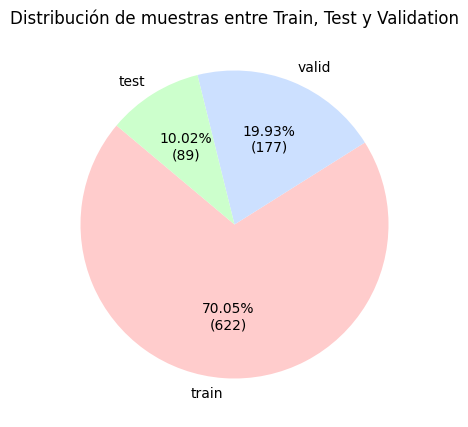

In [ ]:
sizes = []

# Etiquetas y datos para el gráfico
labels = splits

for label in labels:
  sizes.append(len(images_info[label]))

colors = ['#ffcccc', '#cce0ff', '#ccffcc']

def func(pct, allsizes):
    # Mostrar cantidades además de porcentajes
    absolute = round(pct/100.*sum(allsizes))
    return f"{pct:.2f}%\n({absolute})"

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: func(pct, sizes), startangle=140)

plt.title('Distribución de muestras entre Train, Test y Validation')
plt.show()


 - 1 missing annotations
 - 0 null examples  

[['train', 481]]

id: 481
license: 1
file_name: 26131736898_9e6a8cd68f_o_jpg.rf.0afe7aa803afe0a1f051b68d2c4b8e17.jpg
height: 640
width: 640
date_captured: 2024-11-16T21:30:44+00:00


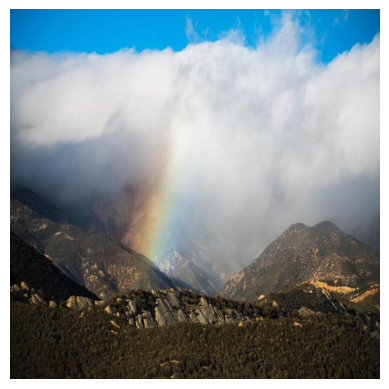

In [ ]:
# Missing annotations
print(missing_annotations)
print()

[[ds_split, miss_ann_image_id]] = missing_annotations

miss_ann_image = [image for image in images_info[ds_split] if image['id'] == miss_ann_image_id]

for key, value in miss_ann_image[0].items():
  print(f'{key}: {value}')

image_path = path + '/' + format + '/' + dataset_name +  '/' + ds_split + '/' + miss_ann_image[0]['file_name']

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()



In [ ]:
print(f'Number of Annotations: {total_ann}')
print(f' - {round(total_ann/total_img, 1)} per image (average)')
print(f' - Across {len(unique_categories)} classes')

Number of Annotations: 2955
 - 3.3 per image (average)
 - Across 2 classes


*The following pre-processing was applied to each image:*
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

*No image augmentation techniques were applied.*

**Auto-orientation of pixel data (with EXIF-orientation stripping)**  

*EXIF (Exchangeable Image File Format)*  
Es un estándar que almacena metadatos dentro de las imágenes, como la fecha de captura, el modelo de la cámara, la configuración de la exposición, y la orientación de la imagen (por ejemplo, si la imagen fue tomada en modo vertical o horizontal).

*Auto-orientation*   
Algunas cámaras o dispositivos móviles ajustan automáticamente la orientación de la imagen cuando la capturan (por ejemplo, si se gira el teléfono de forma vertical a horizontal al tomar la foto). Esto es guardado en los metadatos de la imagen en un campo llamado EXIF Orientation.

*EXIF-orientation stripping*   
Esto se refiere a eliminar o ignorar estos metadatos de orientación al cargar la imagen. La imagen será automáticamente orientada en función de los datos EXIF para que se muestre correctamente (por ejemplo, si la imagen fue tomada de manera invertida o rotada). Después de esta corrección, los metadatos de orientación se eliminan para evitar que interfieran con el procesamiento posterior.

En resumen esto asegura que las imágenes se visualicen en la orientación correcta, ignorando los metadatos EXIF que indican rotación o giro, y eliminando dichos metadatos para evitar confusión más adelante.

**Resize to 640x640 (Stretch)**  
*Resize (Redimensionado)*  
Este paso se refiere a cambiar las dimensiones de la imagen para ajustarla a un tamaño específico, en este caso a 640x640 píxeles. La redimensión es una parte común de la preparación de los datos en visión por computadora, especialmente cuando se entrenan redes neuronales.

*Stretch (Estiramiento)*
Cuando una imagen se redimensiona de manera uniforme (es decir, se hace un cambio de tamaño que no mantiene la relación de aspecto original), se dice que se está "estirando" o "distorsionando" la imagen. En este caso, las imágenes del dataset se ajustan a un tamaño de 640x640 píxeles sin tener en cuenta si la relación de aspecto original (por ejemplo, ancho a alto) es cuadrada o no. Esto puede causar que la imagen se distorsione, lo que significa que los objetos dentro de la imagen pueden aparecer más anchos, más delgados, más altos o más bajos de lo que realmente son.

En resumen, esto asegura que todas las imágenes tengan un tamaño uniforme de 640x640 píxeles, pero puede distorsionar la imagen si la relación de aspecto original no es cuadrada.

* Average Image Size
 - 9.59 mp  
   Significa que el tamaño promedio de las imágenes en el dataset es de 9.59 megapíxeles (mp).
   
   Un megapíxel (mp) es una unidad que se utiliza para medir la resolución de una imagen, y corresponde a un millón de píxeles.   
   Entonces, 9.59 mp significa que el tamaño promedio de las imágenes es de aproximadamente 9.59 millones de píxeles (ancho x alto).

   Rango de tamaños de las imágenes dentro del dataset:

   - from 0.04 mp
   - to 51.13 mp  

  La imagen más pequeña en el dataset tiene 0.04 mp (aproximadamente 40,000 píxeles).  
  La imagen más grande en el dataset tiene 51.13 mp (aproximadamente 51.13 millones de píxeles).  
  Esto significa que el tamaño de las imágenes en el dataset varía significativamente, con algunas imágenes siendo muy pequeñas y otras muy grandes.

Ejemplo:

Una imagen de 0.04 mp podría tener una resolución de 200 x 200 píxeles (40000 píxeles).
Una imagen de 51.13 mp podría tener una resolución de 8000 x 6400 píxeles.  

Este rango de tamaños puede ser importante porque puede afectar el rendimiento del modelo de aprendizaje automático.   


Median Image Ratio: 3264x2448   
(median width by median height image)  
<br>
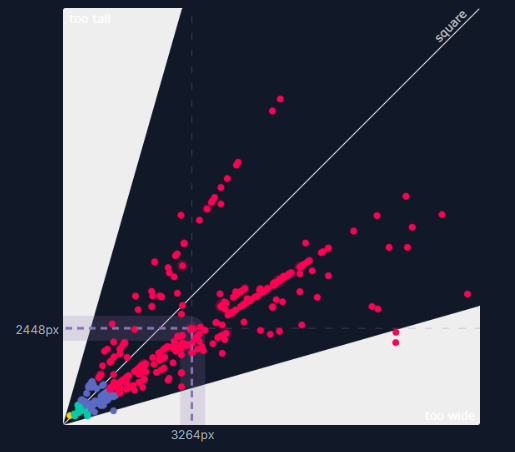

* Size Distribution
(Nro. de pixels en cada imagen)
 - small: 1
 - medium: 19
 - large: : 133
 - jumbo: 735 > 1024x1024

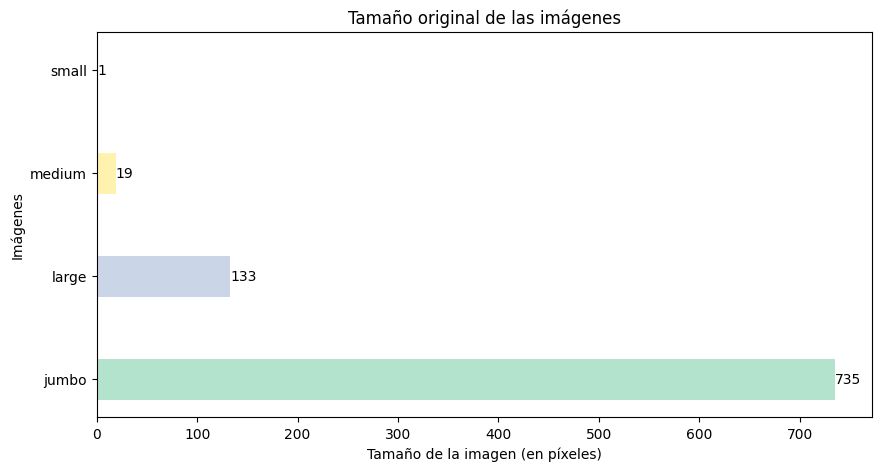

In [ ]:
x_sizes = ["small", "medium", "large", "jumbo"]
y_quantities = [1, 19, 133, 735]
colors = plt.cm.Pastel2(np.linspace(0, 1, len(x_sizes)))

sorted_indexes = np.argsort(y_quantities)[::-1]
x_sizes_sorted = np.array(x_sizes)[sorted_indexes]
y_quantities_sorted = np.array(y_quantities)[sorted_indexes]

plt.figure(figsize=(10, 5))
plt.barh(x_sizes_sorted, y_quantities_sorted, color=colors, height=0.4)
plt.xlabel('Tamaño de la imagen (en píxeles)')
plt.ylabel('Imágenes')
plt.title('Tamaño original de las imágenes')

for index, value in enumerate(y_quantities_sorted):
    plt.text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')

plt.show()



* Class Balance:
 - Smoke: 1832
 - Fire: 1123  

In [ ]:
y_pie = {'full': {}}

for split in splits:
    # Contar las ocurrencias de las categorías
    category_ids = [ann['category_id'] for ann in annotations[split]]
    category_counts = Counter(category_ids)

    # Traducir las claves con el diccionario de categorías
    translated_counts = {category_dict[key]: value for key, value in category_counts.items()}

    # Guardar cada parcial
    y_pie[split] = translated_counts

    # Acumular los conteos en y_pie['full']
    for category, count in translated_counts.items():
        if category in y_pie['full']:
            y_pie['full'][category] += count  # Sumar el conteo si la categoría ya existe
        else:
            y_pie['full'][category] = count  # Inicializar el conteo si la categoría no existe


In [ ]:
pie_x = {}
pie_y = {}

for split, dict_vals in y_pie.items():

  # Inicializar las claves si no existen
  if split not in pie_x:
    pie_x[split] = []
  if split not in pie_y:
    pie_y[split] = []

  # Acumular para el gráfico
  for x, y in dict_vals.items():
    pie_x[split].append(x)
    pie_y[split].append(y)

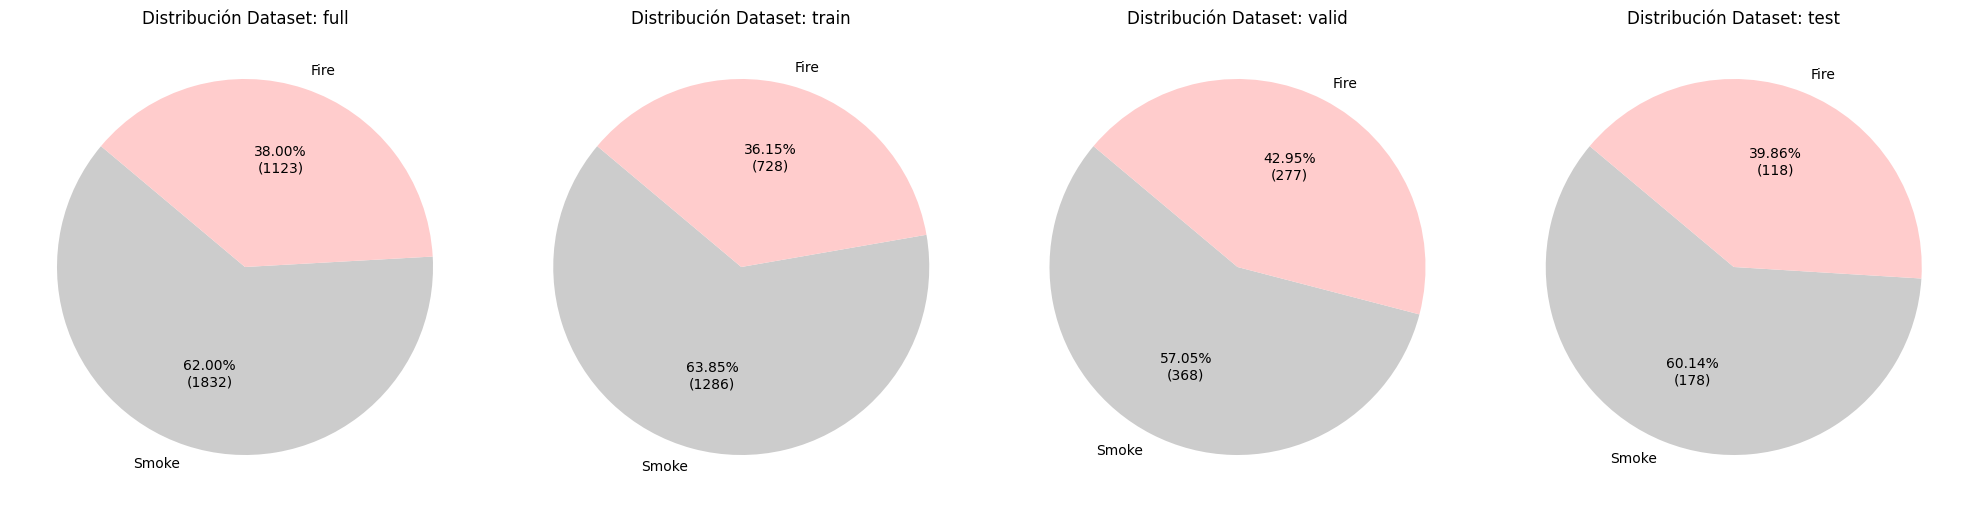

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 fila, 4 columnas

for i, (graph_x, graph_y) in enumerate(zip(pie_x.items(), pie_y.items())):

  axs[i].pie(graph_y[1], labels=graph_x[1],  autopct=lambda pct: func(pct, graph_y[1]), colors=['#cccccc', '#ffcccc'], startangle=140)
  axs[i].set_title(f'Distribución Dataset: {graph_x[0]}')

plt.tight_layout()
plt.show()







* Annotation Heatmap  
Overview of where your annotations are located in the images in your dataset.


In [ ]:
annotations_full = []  # Todas las notaciones
heatmap_dict = {} # Datos para el mapa de calor

for split, annotations_part in annotations.items():
  annotations_full.extend(annotations_part)
  heatmap_dict[split] = annotations_part

heatmap_dict['full'] = annotations_full

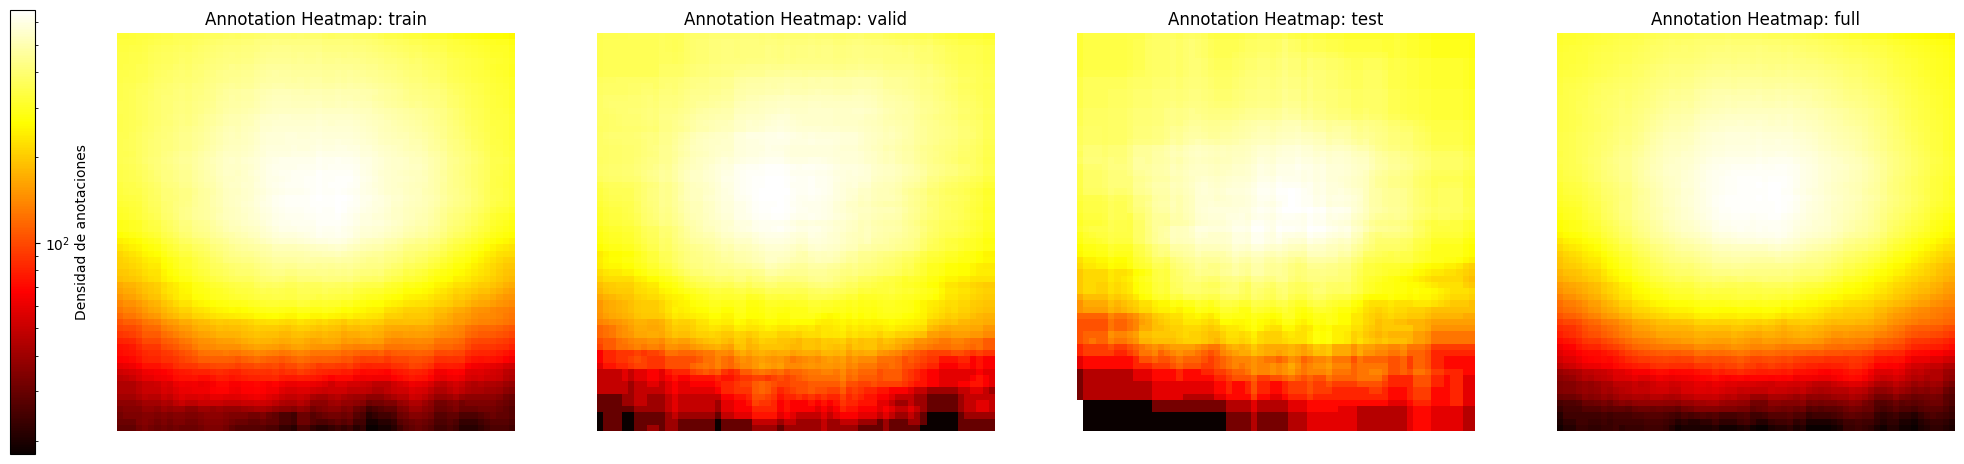

In [ ]:
# Tamaño de la imagen
image_width = 640
image_height = 640

# Configurar la cuadrícula: 10x10
grid_size = 10
grid_width = image_width // grid_size
grid_height = image_height // grid_size

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 5, width_ratios=[0.25, 4, 4, 4, 4])

# Iterar sobre cada conjunto de anotaciones
for idx, (split, annots) in enumerate(heatmap_dict.items()):

  # Crear una matriz vacía para el conteo de las celdas del heatmap
  heatmap = np.zeros((grid_height, grid_width))

  # Contar las anotaciones en cada celda
  for ann in annots:
      x_min, y_min, w, h = ann['bbox']

      # Asegurar que las coordenadas no se salgan de los límites de la imagen
      x_min = max(0, x_min)
      y_min = max(0, y_min)
      x_max = min(image_width, x_min + w)
      y_max = min(image_height, y_min + h)

      # Obtener las celdas que cubren la caja delimitadora
      x_start = int(x_min // grid_size)
      y_start = int(y_min // grid_size)
      x_end = int((x_min + w) // grid_size)
      y_end = int((y_min + h) // grid_size)

      # Asegurar que los índices no se salgan de la cuadrícula
      x_end = min(x_end, grid_width - 1)
      y_end = min(y_end, grid_height - 1)

      # Incrementar las celdas que cubren la caja delimitadora
      for y in range(y_start, y_end + 1):
          for x in range(x_start, x_end + 1):
              heatmap[y, x] += 1

  # Dibujar el mapa de calor en la subgráfica correspondiente
  ax = fig.add_subplot(gs[0, idx+1])
  # LogNorm para una mejor visualización de la densidad
  im = ax.imshow(heatmap, cmap='hot', interpolation='nearest', norm=LogNorm())
  ax.set_title(f"Annotation Heatmap: {split}")
  ax.axis('off')

# Agregar la barra de color en la primera columna de la cuadrícula (común para todos)
cbar_ax = fig.add_subplot(gs[0, 0])
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Densidad de anotaciones')

plt.tight_layout(pad=2.0)
plt.show()



En este mapa de calor, el color amarillo representa los valores más bajos, mientras que el rojo representa los valores más altos.
Las celdas más amarillas indican que la densidad de anotaciones es baja en esas áreas.
Los rojos indican áreas donde las anotaciones son mucho más densas o frecuentes (alta concentración de anotaciones)

* Histogram of Object Count by Image  
Overview of how many classes are annotated in each image in your dataset.

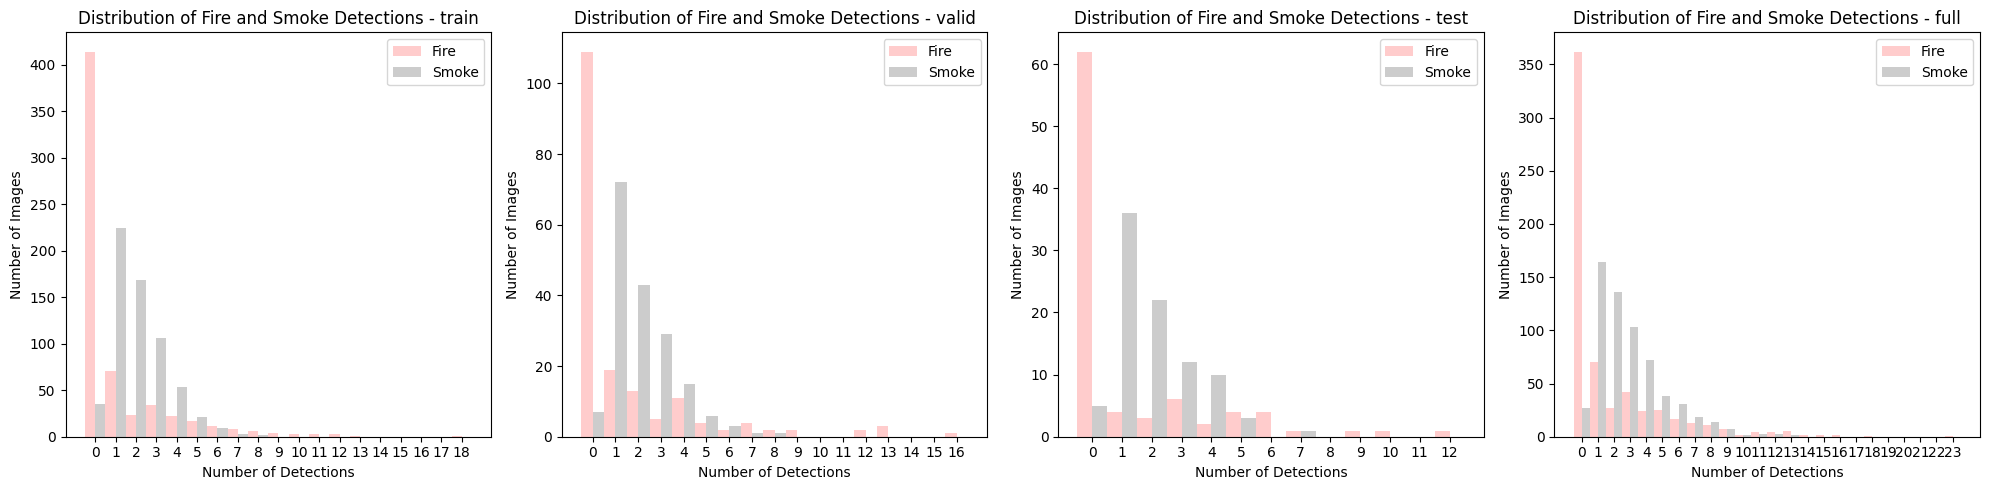

In [ ]:
# Crear una figura con 4 subgráficos
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Iterar sobre cada conjunto de anotaciones
for idx, (split, annots) in enumerate(heatmap_dict.items()):

    counts_by_image = defaultdict(lambda: {category.lower(): 0 for category in unique_categories})
    fire_counts_all = []
    smoke_counts_all = []

    # Contar las detecciones por imagen
    for annotation in annots:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        counts_by_image[image_id][str(category_dict[category_id]).lower()] += 1

    # Extraer los conteos para las imágenes
    image_ids = list(counts_by_image.keys())
    fire_counts = [counts_by_image[image_id]['fire'] for image_id in image_ids]
    smoke_counts = [counts_by_image[image_id]['smoke'] for image_id in image_ids]

    fire_counts_all.extend(fire_counts)
    smoke_counts_all.extend(smoke_counts)

    # Definir el rango de bins para el histograma de fire y smoke (mismo rango de bins)
    min_detections = min(min(fire_counts_all), min(smoke_counts_all))
    max_detections = max(max(fire_counts_all), max(smoke_counts_all))

    # Ajustar el rango de bins
    bins = np.arange(min_detections, max_detections + 2) - 0.5

    # Calcular los histogramas para fire y smoke con el mismo rango de bins
    fire_hist, bin_edges = np.histogram(fire_counts_all, bins=bins)
    smoke_hist, _ = np.histogram(smoke_counts_all, bins=bins)

    # Crear gráfico de barras agrupadas
    x = bin_edges[:-1] + 0.5  # Usar los bins de fire como base para el eje X
    bar_width = 0.5

    # Graficar las barras de 'fire' y 'smoke' en el mismo gráfico
    axs[idx].bar(x - bar_width / 2, fire_hist, bar_width, label='Fire', color='#ffcccc')
    axs[idx].bar(x + bar_width / 2, smoke_hist, bar_width, label='Smoke', color='#cccccc')

    # Configuración del gráfico
    axs[idx].set_xlabel('Number of Detections')
    axs[idx].set_ylabel('Number of Images')
    axs[idx].set_title(f'Distribution of Fire and Smoke Detections - {split}')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels([str(int(i)) for i in x])
    axs[idx].legend()

plt.tight_layout()
plt.show()
